In [23]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model ,Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!matplotlib inline
np.random.seed(0)

'matplotlib' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
episodes=pd.read_csv('episodes_cleaned.csv',index_col='Unnamed: 0')
scripts=pd.read_csv('scripts_cleaned.csv',index_col='Unnamed: 0')

In [3]:
episodes['Larry']=0
for ep in episodes.iterrows():
    names=(ep[1][4].replace(' and ',',').split(','))
    for name in names:
        if 'Larry David' in name:
            episodes['Larry'][ep[0]]=1
larry_eps=list(episodes.loc[episodes.Larry==1]['SEID'])
    

C:\kosta\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
episodes.Larry.sum()

58

In [5]:
scripts['Larry']=0
for ep in larry_eps:
    scripts.loc[scripts['SEID']==ep,'Larry']=1
scripts.head()

,Character,Dialogue,EpisodeNo,SEID,Season,character_stripped,Larry
0,jerry,do you know what this is all about? do you kno...,0.0,S01E00,1.0,jerry,1
1,jerry,"(pointing at georges shirt) see, to me, that b...",0.0,S01E00,1.0,jerry,1
2,george,are you through?,0.0,S01E00,1.0,george,1
3,jerry,"you do of course try on, when you buy?",0.0,S01E00,1.0,jerry,1
4,george,"yes, it was purple, i liked it, i dont actuall...",0.0,S01E00,1.0,george,1


In [6]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(scripts['Dialogue'].values))
list_tokenized_train = tokenizer.texts_to_sequences(scripts.Dialogue.values)
X_t = pad_sequences(list_tokenized_train,maxlen=100)
y=scripts.Larry.values

In [14]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_t, y) 

In [15]:
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_resampled,y_resampled)

In [19]:
embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(20000,embedding_size)(input_)
x = Bidirectional(GRU(200,return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(200,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1,activation='sigmoid')(x)

model2 = Model(inputs=input_,outputs=x)
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

checkpoints_path = 'weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

history2=model2.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 844s 17ms/step - loss: 0.6729 - acc: 0.5690 - val_loss: 0.6284 - val_acc: 0.6519

Epoch 00001: val_loss improved from inf to 0.62844, saving model to weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 853s 18ms/step - loss: 0.5469 - acc: 0.7137 - val_loss: 0.5649 - val_acc: 0.6841

Epoch 00002: val_loss improved from 0.62844 to 0.56493, saving model to weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 865s 18ms/step - loss: 0.4405 - acc: 0.7728 - val_loss: 0.6217 - val_acc: 0.6767

Epoch 00003: val_loss did not improve from 0.56493
Epoch 4/5
48714/48714 [==============================] - 849s 17ms/step - loss: 0.3726 - acc: 0.8045 - val_loss: 0.6861 - val_acc: 0.6758

Epoch 00004: val_loss did not improve from 0.56493
Epoch 5/5
48714/48714 [==============================] - 848s 17ms/step - loss: 0.3303 - acc: 0.8237 - val_

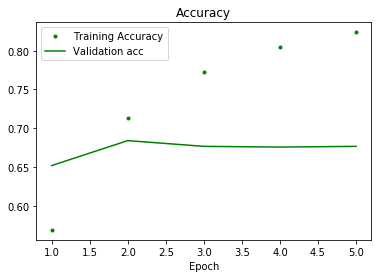

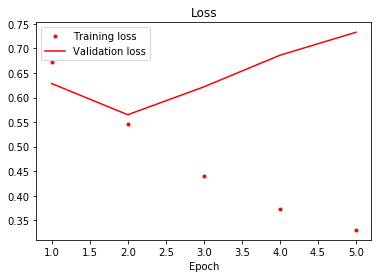

In [21]:
train_acc = history2.history['acc']
val_acc = history2.history['val_acc']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [20]:
model2.evaluate(X_r_test,y_r_test)

18043/18043 [==============================] - 68s 4ms/step


[0.6840890984422107, 0.688244748652685]

In [27]:
lstm_model = Sequential()
lstm_model.add(Embedding(20000,128))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(GlobalMaxPool1D())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'lstm_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

lstm_history=lstm_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 236s 5ms/step - loss: 0.6663 - acc: 0.5794 - val_loss: 0.6178 - val_acc: 0.6375

Epoch 00001: val_loss improved from inf to 0.61776, saving model to lstm_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 236s 5ms/step - loss: 0.5542 - acc: 0.6999 - val_loss: 0.5923 - val_acc: 0.6606

Epoch 00002: val_loss improved from 0.61776 to 0.59230, saving model to lstm_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 228s 5ms/step - loss: 0.4653 - acc: 0.7544 - val_loss: 0.6210 - val_acc: 0.6588

Epoch 00003: val_loss did not improve from 0.59230
Epoch 4/5
48714/48714 [==============================] - 225s 5ms/step - loss: 0.4080 - acc: 0.7840 - val_loss: 0.6628 - val_acc: 0.6723

Epoch 00004: val_loss did not improve from 0.59230
Epoch 5/5
48714/48714 [==============================] - 225s 5ms/step - loss: 0.3704 - acc: 0.8015 -

In [31]:
lstm_bi_model = Sequential()
lstm_bi_model.add(Embedding(20000,128))
lstm_bi_model.add(Bidirectional(LSTM(50, return_sequences=True)))
lstm_bi_model.add(GlobalMaxPool1D())
lstm_bi_model.add(Dropout(0.5))
lstm_bi_model.add(Dense(1, activation='sigmoid'))

lstm_bi_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'lstm_bi_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

lstm_bi_history=lstm_bi_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 392s 8ms/step - loss: 0.6581 - acc: 0.5932 - val_loss: 0.6080 - val_acc: 0.6477

Epoch 00001: val_loss improved from inf to 0.60798, saving model to lstm_bi_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 389s 8ms/step - loss: 0.5342 - acc: 0.7170 - val_loss: 0.5997 - val_acc: 0.6651

Epoch 00002: val_loss improved from 0.60798 to 0.59973, saving model to lstm_bi_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 367s 8ms/step - loss: 0.4426 - acc: 0.7685 - val_loss: 0.6212 - val_acc: 0.6662

Epoch 00003: val_loss did not improve from 0.59973
Epoch 4/5
48714/48714 [==============================] - 376s 8ms/step - loss: 0.3860 - acc: 0.7963 - val_loss: 0.6912 - val_acc: 0.6656

Epoch 00004: val_loss did not improve from 0.59973
Epoch 5/5
48714/48714 [==============================] - 355s 7ms/step - loss: 0.3453 - acc: 0.

In [28]:
gru_model = Sequential()
gru_model.add(Embedding(20000,128))
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(GlobalMaxPool1D())
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_history=gru_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 199s 4ms/step - loss: 0.6625 - acc: 0.5855 - val_loss: 0.6139 - val_acc: 0.6447

Epoch 00001: val_loss improved from inf to 0.61387, saving model to gru_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 195s 4ms/step - loss: 0.5442 - acc: 0.7084 - val_loss: 0.5835 - val_acc: 0.6693

Epoch 00002: val_loss improved from 0.61387 to 0.58347, saving model to gru_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 205s 4ms/step - loss: 0.4491 - acc: 0.7660 - val_loss: 0.6024 - val_acc: 0.6789

Epoch 00003: val_loss did not improve from 0.58347
Epoch 4/5
48714/48714 [==============================] - 218s 4ms/step - loss: 0.3906 - acc: 0.7968 - val_loss: 0.6301 - val_acc: 0.6675

Epoch 00004: val_loss did not improve from 0.58347
Epoch 5/5
48714/48714 [==============================] - 227s 5ms/step - loss: 0.3507 - acc: 0.8155 - v

In [33]:
gru_bi_model = Sequential()
gru_bi_model.add(Embedding(20000,128))
gru_bi_model.add(Bidirectional(GRU(50, return_sequences=True)))
gru_bi_model.add(GlobalMaxPool1D())
gru_bi_model.add(Dropout(0.5))
gru_bi_model.add(Dense(1, activation='sigmoid'))

gru_bi_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi_history=gru_bi_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 318s 7ms/step - loss: 0.6567 - acc: 0.5928 - val_loss: 0.6021 - val_acc: 0.6649

Epoch 00001: val_loss improved from inf to 0.60212, saving model to gru_bi_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 319s 7ms/step - loss: 0.5299 - acc: 0.7199 - val_loss: 0.5968 - val_acc: 0.6669

Epoch 00002: val_loss improved from 0.60212 to 0.59681, saving model to gru_bi_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 321s 7ms/step - loss: 0.4321 - acc: 0.7781 - val_loss: 0.6147 - val_acc: 0.6706

Epoch 00003: val_loss did not improve from 0.59681
Epoch 4/5
48714/48714 [==============================] - 320s 7ms/step - loss: 0.3701 - acc: 0.8088 - val_loss: 0.6411 - val_acc: 0.6863

Epoch 00004: val_loss did not improve from 0.59681
Epoch 5/5
48714/48714 [==============================] - 339s 7ms/step - loss: 0.3266 - acc: 0.82

In [35]:
gru_bi2_model = Sequential()
gru_bi2_model.add(Embedding(20000,128))
gru_bi2_model.add(Bidirectional(GRU(50, return_sequences=True)))
gru_bi2_model.add(GlobalMaxPool1D())
gru_bi2_model.add(Dense(50,activation='relu'))
gru_bi2_model.add(Dense(1, activation='sigmoid'))

gru_bi2_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi2_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi2_history=gru_bi2_model.fit(X_r_train,y_r_train,batch_size=32,epochs=5,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/5
48714/48714 [==============================] - 313s 6ms/step - loss: 0.6409 - acc: 0.6096 - val_loss: 0.5868 - val_acc: 0.6688

Epoch 00001: val_loss improved from inf to 0.58677, saving model to gru_bi2_weights_base.best.hdf5
Epoch 2/5
48714/48714 [==============================] - 314s 6ms/step - loss: 0.4915 - acc: 0.7423 - val_loss: 0.5794 - val_acc: 0.6762

Epoch 00002: val_loss improved from 0.58677 to 0.57943, saving model to gru_bi2_weights_base.best.hdf5
Epoch 3/5
48714/48714 [==============================] - 295s 6ms/step - loss: 0.3845 - acc: 0.8023 - val_loss: 0.6614 - val_acc: 0.6715

Epoch 00003: val_loss did not improve from 0.57943
Epoch 4/5
48714/48714 [==============================] - 322s 7ms/step - loss: 0.3186 - acc: 0.8316 - val_loss: 0.7555 - val_acc: 0.6680

Epoch 00004: val_loss did not improve from 0.57943
Epoch 5/5
48714/48714 [==============================] - 317s 7ms/step - loss: 0.2722 - acc: 0.

In [36]:
gru_bi2d_model = Sequential()
gru_bi2d_model.add(Embedding(20000,128))
gru_bi2d_model.add(Bidirectional(GRU(50, return_sequences=True)))
gru_bi2d_model.add(GlobalMaxPool1D())
gru_bi2d_model.add(Dense(50,activation='relu'))
gru_bi2d_model.add(Dropout(0.2))
gru_bi2d_model.add(Dense(1, activation='sigmoid'))

gru_bi2d_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi2d_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi2d_history=gru_bi2d_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 299s 6ms/step - loss: 0.6444 - acc: 0.6105 - val_loss: 0.5961 - val_acc: 0.6608

Epoch 00001: val_loss improved from inf to 0.59606, saving model to gru_bi2d_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 305s 6ms/step - loss: 0.5011 - acc: 0.7373 - val_loss: 0.5708 - val_acc: 0.6828

Epoch 00002: val_loss improved from 0.59606 to 0.57078, saving model to gru_bi2d_weights_base.best.hdf5
Epoch 3/4
48714/48714 [==============================] - 298s 6ms/step - loss: 0.3962 - acc: 0.7944 - val_loss: 0.6305 - val_acc: 0.6763

Epoch 00003: val_loss did not improve from 0.57078
Epoch 4/4
48714/48714 [==============================] - 300s 6ms/step - loss: 0.3273 - acc: 0.8258 - val_loss: 0.6768 - val_acc: 0.6854

Epoch 00004: val_loss did not improve from 0.57078


In [37]:
gru_bi2d_model = Sequential()
gru_bi2d_model.add(Embedding(20000,128))
gru_bi2d_model.add(Bidirectional(GRU(100, return_sequences=True)))
gru_bi2d_model.add(GlobalMaxPool1D())
gru_bi2d_model.add(Dense(100,activation='relu'))
gru_bi2d_model.add(Dropout(0.2))
gru_bi2d_model.add(Dense(50,activation='relu'))
gru_bi2d_model.add(Dropout(0.2))
gru_bi2d_model.add(Dense(1, activation='sigmoid'))

gru_bi2d_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi2d_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi2d_history=gru_bi2d_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 448s 9ms/step - loss: 0.6459 - acc: 0.6075 - val_loss: 0.5831 - val_acc: 0.6762

Epoch 00001: val_loss improved from inf to 0.58311, saving model to gru_bi2d_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 412s 8ms/step - loss: 0.5007 - acc: 0.7354 - val_loss: 0.5849 - val_acc: 0.6887

Epoch 00002: val_loss did not improve from 0.58311
Epoch 3/4
48714/48714 [==============================] - 393s 8ms/step - loss: 0.3957 - acc: 0.7911 - val_loss: 0.6475 - val_acc: 0.6786

Epoch 00003: val_loss did not improve from 0.58311
Epoch 4/4
48714/48714 [==============================] - 400s 8ms/step - loss: 0.3269 - acc: 0.8251 - val_loss: 0.7372 - val_acc: 0.6852

Epoch 00004: val_loss did not improve from 0.58311


In [38]:
gru_3l_bi2d_model = Sequential()
gru_3l_bi2d_model.add(Embedding(20000,128))
gru_3l_bi2d_model.add(Bidirectional(GRU(200, return_sequences=True)))
gru_3l_bi2d_model.add(GlobalMaxPool1D())
gru_3l_bi2d_model.add(Dense(200,activation='relu'))
gru_3l_bi2d_model.add(Dropout(0.2))
gru_3l_bi2d_model.add(Dense(100,activation='relu'))
gru_3l_bi2d_model.add(Dropout(0.2))
gru_3l_bi2d_model.add(Dense(50,activation='relu'))
gru_3l_bi2d_model.add(Dropout(0.2))
gru_3l_bi2d_model.add(Dense(1, activation='sigmoid'))

gru_3l_bi2d_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_3l_bi2d_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_3l_bi2d_history=gru_3l_bi2d_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 800s 16ms/step - loss: 0.6569 - acc: 0.5864 - val_loss: 0.5913 - val_acc: 0.6669

Epoch 00001: val_loss improved from inf to 0.59128, saving model to gru_3l_bi2d_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 762s 16ms/step - loss: 0.5149 - acc: 0.7262 - val_loss: 0.5694 - val_acc: 0.6804

Epoch 00002: val_loss improved from 0.59128 to 0.56938, saving model to gru_3l_bi2d_weights_base.best.hdf5
Epoch 3/4
48714/48714 [==============================] - 788s 16ms/step - loss: 0.4100 - acc: 0.7856 - val_loss: 0.6255 - val_acc: 0.6837

Epoch 00003: val_loss did not improve from 0.56938
Epoch 4/4
48714/48714 [==============================] - 800s 16ms/step - loss: 0.3410 - acc: 0.8187 - val_loss: 0.6906 - val_acc: 0.6830

Epoch 00004: val_loss did not improve from 0.56938


In [39]:
gru_bi_l1_model = Sequential()
gru_bi_l1_model.add(Embedding(20000,128))
gru_bi_l1_model.add(Bidirectional(GRU(50, return_sequences=True)))
gru_bi_l1_model.add(GlobalMaxPool1D())
gru_bi_l1_model.add(Dense(50,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_bi_l1_model.add(Dense(1, activation='sigmoid'))

gru_bi_l1_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_bi_l1_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_bi_l1_history=gru_bi_l1_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 350s 7ms/step - loss: 0.8098 - acc: 0.5010 - val_loss: 0.6960 - val_acc: 0.5138

Epoch 00001: val_loss improved from inf to 0.69602, saving model to gru_bi_l1_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 450s 9ms/step - loss: 0.6961 - acc: 0.4954 - val_loss: 0.6960 - val_acc: 0.5138

Epoch 00002: val_loss improved from 0.69602 to 0.69602, saving model to gru_bi_l1_weights_base.best.hdf5
Epoch 3/4
48714/48714 [==============================] - 449s 9ms/step - loss: 0.6961 - acc: 0.4997 - val_loss: 0.6959 - val_acc: 0.5138

Epoch 00003: val_loss improved from 0.69602 to 0.69593, saving model to gru_bi_l1_weights_base.best.hdf5
Epoch 4/4
48714/48714 [==============================] - 363s 7ms/step - loss: 0.6961 - acc: 0.5009 - val_loss: 0.6961 - val_acc: 0.4862

Epoch 00004: val_loss did not improve from 0.69593


In [40]:
gru_3l1_bi2d_model = Sequential()
gru_3l1_bi2d_model.add(Embedding(20000,128))
gru_3l1_bi2d_model.add(Bidirectional(GRU(200, return_sequences=True)))
gru_3l1_bi2d_model.add(GlobalMaxPool1D())
gru_3l1_bi2d_model.add(Dense(200,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_3l1_bi2d_model.add(Dropout(0.2))
gru_3l1_bi2d_model.add(Dense(100,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_3l1_bi2d_model.add(Dropout(0.2))
gru_3l1_bi2d_model.add(Dense(50,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_3l1_bi2d_model.add(Dropout(0.2))
gru_3l1_bi2d_model.add(Dense(1, activation='sigmoid'))

gru_3l1_bi2d_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_3l1_bi2d_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_3l1_bi2d_history=gru_3l1_bi2d_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 1313s 27ms/step - loss: 1.5539 - acc: 0.5027 - val_loss: 0.7589 - val_acc: 0.4862

Epoch 00001: val_loss improved from inf to 0.75892, saving model to gru_3l1_bi2d_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 1458s 30ms/step - loss: 0.7588 - acc: 0.4986 - val_loss: 0.7592 - val_acc: 0.4862

Epoch 00002: val_loss did not improve from 0.75892
Epoch 3/4
48714/48714 [==============================] - 1015s 21ms/step - loss: 0.7588 - acc: 0.4968 - val_loss: 0.7586 - val_acc: 0.4862

Epoch 00003: val_loss improved from 0.75892 to 0.75862, saving model to gru_3l1_bi2d_weights_base.best.hdf5
Epoch 4/4
 1056/48714 [..............................] - ETA: 16:16 - loss: 0.7587 - acc: 0.5104

KeyboardInterrupt: 

In [ ]:
gru_3l1_bi_model = Sequential()
gru_3l1_bi_model.add(Embedding(20000,128))
gru_3l1_bi_model.add(Bidirectional(GRU(200, return_sequences=True)))
gru_3l1_bi_model.add(GlobalMaxPool1D())
gru_3l1_bi_model.add(Dense(200,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_3l1_bi_model.add(Dense(100,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_3l1_bi_model.add(Dense(50,activation='relu',kernel_regularizer=regularizers.l1(0.005)))
gru_3l1_bi_model.add(Dense(1, activation='sigmoid'))

gru_3l1_bi_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_3l1_bi_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_3l1_bi_history=gru_3l1_bi_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 979s 20ms/step - loss: 1.5565 - acc: 0.4964 - val_loss: 0.7584 - val_acc: 0.5138

Epoch 00001: val_loss improved from inf to 0.75835, saving model to gru_3l1_bi_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 1007s 21ms/step - loss: 0.7588 - acc: 0.5029 - val_loss: 0.7589 - val_acc: 0.5138

Epoch 00002: val_loss did not improve from 0.75835
Epoch 3/4
 1472/48714 [..............................] - ETA: 20:24 - loss: 0.7588 - acc: 0.4993

In [44]:
gru_3l_bi2d5_model = Sequential()
gru_3l_bi2d5_model.add(Embedding(20000,128))
gru_3l_bi2d5_model.add(Bidirectional(GRU(200, return_sequences=True)))
gru_3l_bi2d5_model.add(GlobalMaxPool1D())
gru_3l_bi2d5_model.add(Dense(200,activation='relu'))
gru_3l_bi2d5_model.add(Dropout(0.5))
gru_3l_bi2d5_model.add(Dense(100,activation='relu'))
gru_3l_bi2d5_model.add(Dropout(0.5))
gru_3l_bi2d5_model.add(Dense(50,activation='relu'))
gru_3l_bi2d5_model.add(Dropout(0.5))
gru_3l_bi2d5_model.add(Dense(1, activation='sigmoid'))

gru_3l_bi2d5_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

checkpoints_path = 'gru_3l_bi2d5_weights_base.best.hdf5'
checkpoint = [ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')]

gru_3l_bi2d5_history=gru_3l_bi2d5_model.fit(X_r_train,y_r_train,batch_size=32,epochs=4,validation_split=0.1, callbacks=checkpoint)

Train on 48714 samples, validate on 5413 samples
Epoch 1/4
48714/48714 [==============================] - 765s 16ms/step - loss: 0.6922 - acc: 0.5249 - val_loss: 0.6782 - val_acc: 0.5930

Epoch 00001: val_loss improved from inf to 0.67824, saving model to gru_3l_bi2d5_weights_base.best.hdf5
Epoch 2/4
48714/48714 [==============================] - 751s 15ms/step - loss: 0.6113 - acc: 0.6627 - val_loss: 0.5802 - val_acc: 0.6773

Epoch 00002: val_loss improved from 0.67824 to 0.58018, saving model to gru_3l_bi2d5_weights_base.best.hdf5
Epoch 3/4
48714/48714 [==============================] - 779s 16ms/step - loss: 0.4849 - acc: 0.7518 - val_loss: 0.5824 - val_acc: 0.6835

Epoch 00003: val_loss did not improve from 0.58018
Epoch 4/4
48714/48714 [==============================] - 783s 16ms/step - loss: 0.3999 - acc: 0.7940 - val_loss: 0.6566 - val_acc: 0.6717

Epoch 00004: val_loss did not improve from 0.58018
